# Make MasterFlat CTIO Data in June 2017
==================================================================================================

- author : Sylvie Dagoret-Campagne
- date   : June 4th 2017


This notebook computes the MasterFlat.
This is inspired form ccdprocs (astropy)

### This notebook computes the Master Flat
-----------------------------------------





In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from astropy.modeling import models
from astropy import units as u
from astropy import nddata
from astropy.io import fits
import re
import os

In [2]:
import ccdproc
print 'ccdproc version',ccdproc.__version__
from astropy.modeling import models
from ccdproc import CCDData, Combiner

ccdproc version 1.2.0


In [3]:
from scipy import stats  
from scipy import ndimage
from datetime import datetime, timedelta
from mpl_toolkits.mplot3d import Axes3D
import scipy.signal

In [4]:
import bottleneck as bn  # numpy's masked median is slow...really slow (in version 1.8.1 and lower)
print 'bottleneck version',bn.__version__

bottleneck version 1.2.1


In [5]:
import photutils
from astropy.stats import sigma_clipped_stats
#from photutils import daofind
#from photutils import CircularAperture
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
#from photutils.background import Background2D
#from photutils import Background2D, SigmaClip, MedianBackground

In [6]:
from IPython.display import Image, display

In [7]:
import matplotlib
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 

In [8]:
# to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (8, 8),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

In [9]:
############################################################################
def ensure_dir(f):
    d = os.path.dirname(f)
    if not os.path.exists(f):
        os.makedirs(f)
#########################################################################

In [10]:
imstats = lambda dat: (dat.min(), dat.max(), dat.mean(), dat.std())

## Definitions


## location of bias and flats

/sps/lsst/data/AtmosphericCalibration/CTIODataJune2017/Flats_et_bias

In [11]:
inputbiasfile="median_bias.fits"

In [14]:
#inputflatfile="RG715_median_flat.fits"
#inputflatfile="fGB37__median_flat.fits"
inputflatfile="H_alpha_median_flat.fits"

In [15]:
outputflatfile="FinalMasterFlat_CTIO_HALPHA.fits"

In [16]:
def bn_median(masked_array, axis=None):
    """
    Perform fast median on masked array
    
    Parameters
    ----------
    
    masked_array : `numpy.ma.masked_array`
        Array of which to find the median.
    
    axis : int, optional
        Axis along which to perform the median. Default is to find the median of
        the flattened array.
    """
    data = masked_array.filled(fill_value=np.NaN)
    med = bn.nanmedian(data, axis=axis)
    # construct a masked array result, setting the mask from any NaN entries
    return np.ma.array(med, mask=np.isnan(med))

In [17]:
def avg_over_images(masked_arr, axis=0):
    """
    Calculate average pixel value along specified axis
    """
    return ma.mean(masked_arr, axis=axis)

def med_over_images(masked_arr, axis=0):
    """
    Calculate median pixel value along specified axis
    
    Uses bottleneck.nanmedian for speed
    """
    
    dat = masked_arr.data.copy()
    dat[masked_arr.mask] = np.NaN
    return bn.nanmedian(dat, axis=axis)

In [18]:
imstats = lambda dat: (dat.min(), dat.max(), dat.mean(), dat.std())

## Open Master Bias
===============================

In [19]:
master_bias_in = ccdproc.CCDData.read(inputbiasfile,unit=u.adu)

In [20]:
master_flat_in = ccdproc.CCDData.read(inputflatfile,unit=u.adu)

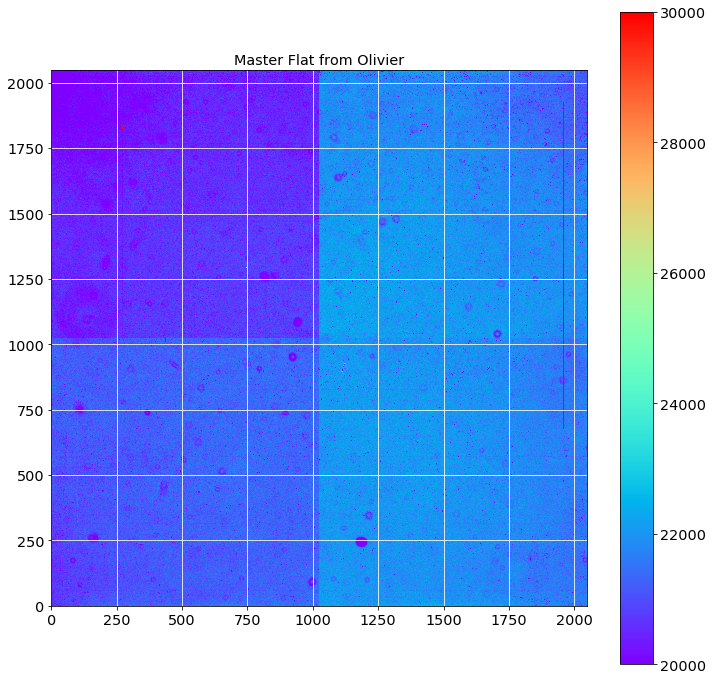

In [21]:
plt.figure(figsize=(12, 12))
#plt.imshow(master_bias, vmax=bias_mean + bias_std, vmin=bias_mean - bias_std)
im=plt.imshow(master_flat_in,origin='lower',cmap='rainbow',vmin=20000.,vmax=30000)
plt.grid(color='white', ls='solid')
plt.grid(True)
plt.colorbar()
title='Master Flat from Olivier'
plt.title(title)
plt.savefig('MasterFlatCCDIn.png')

In [22]:
flatten_flat_in=master_flat_in.data.flatten()

In [23]:
flat_min, flat_max, flat_mean, flat_std = imstats(np.asarray(master_flat_in))

In [24]:
flat_min, flat_max, flat_mean, flat_std 

(12.808586477342798,
 65925.138948913314,
 21365.768303151443,
 1136.0450509573368)

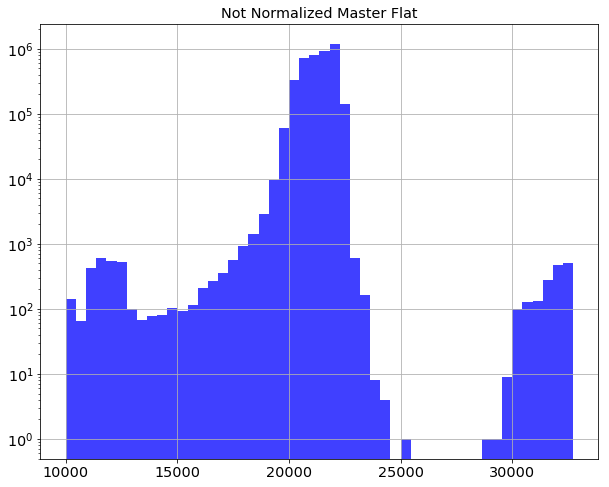

In [25]:
plt.figure(figsize=(10,8))
plt.hist(flatten_flat_in,bins=50,range=(flat_mean-10*flat_std,flat_mean+10*flat_std),facecolor='blue', alpha=0.75);
plt.yscale('log')
plt.grid(True)
title='Not Normalized Master Flat'
plt.title(title)
plt.savefig('NotNormalizedMasterFlatHISTO.png')

In [26]:
flat_combiner = Combiner([master_flat_in])

In [27]:
flat_combiner.sigma_clipping(func=med_over_images)

In [28]:
#scaling_func = lambda arr: 1/np.ma.average(arr)
scaling_func= lambda arr: 1/np.ma.median(arr)
flat_combiner.scaling = scaling_func

In [29]:
master_flat = flat_combiner.median_combine(median_func=bn_median)

## Result on Master Flat
===============================

In [30]:
flat_min, flat_max, flat_mean, flat_std = imstats(np.asarray(master_flat))

In [31]:
print flat_min, flat_max, flat_mean, flat_std

0.000597192559752 3.07371953576 0.996165961529 0.0529674100397


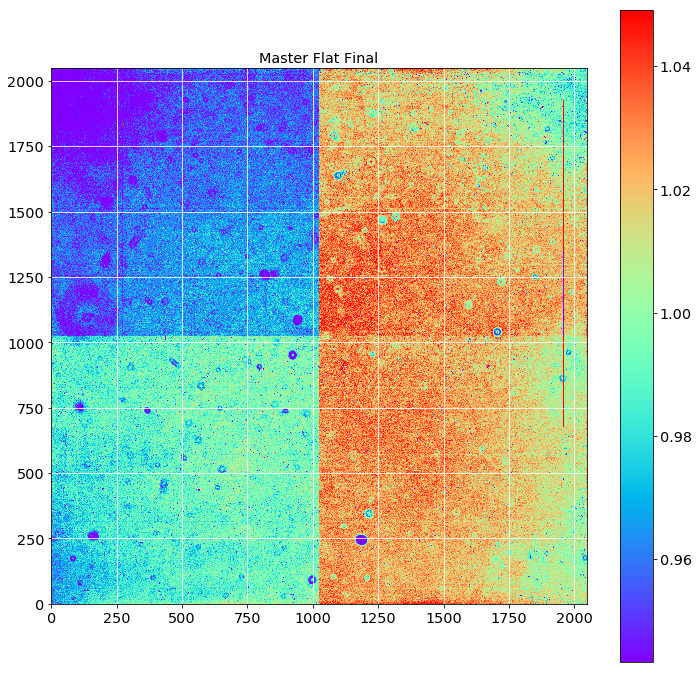

In [32]:
plt.figure(figsize=(12, 12))
#plt.imshow(master_bias, vmax=bias_mean + bias_std, vmin=bias_mean - bias_std)
#plt.imshow(master_flat, vmax=flat_mean+1*flat_std, vmin=flat_mean-1*flat_std)
im=plt.imshow(master_flat,origin='lower',cmap='rainbow',vmax=flat_mean+1*flat_std, vmin=flat_mean-1*flat_std)       
plt.grid(color='white', ls='solid')
plt.colorbar()
title='Master Flat Final'
plt.title(title)
plt.savefig('MasterFlatCCD.png')

In [33]:
flatten_flat=master_flat.data.flatten()

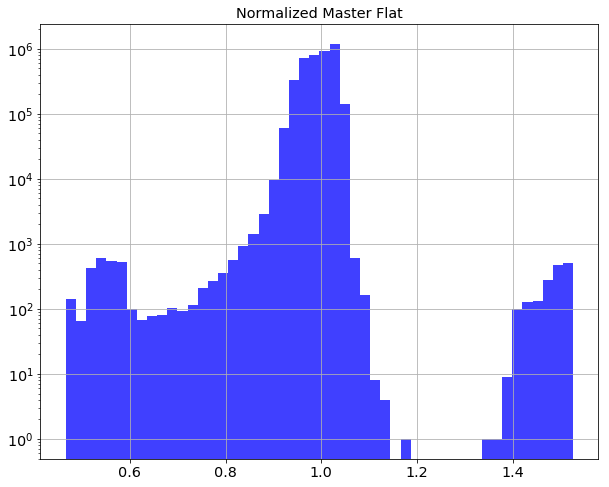

In [34]:
plt.figure(figsize=(10,8))
plt.hist(flatten_flat,bins=50,range=(flat_mean-10*flat_std,flat_mean+10*flat_std),facecolor='blue', alpha=0.75);
plt.yscale('log')
plt.grid(True)
title='Normalized Master Flat'
plt.title(title)
plt.savefig('NormalizedMasterFlatHISTO.png')

## Save the Master Flat
----------------------------------------------------------

In [35]:
prihdu = fits.PrimaryHDU(data=master_flat.data)
thdulist = fits.HDUList(prihdu)
thdulist.writeto(outputflatfile,overwrite=True)